In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single

In [2]:
def plot_synthetic_data(K, L, sample_length, C, seed, mu, o1, o2, fs=1000, start=0):
    T = sample_length/fs
    trange = [0,T]
    data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}'
    c = 0

    data_load = pickle_open(data_path)

    Gamma = data_load['latent']['Gamma']
    xs = data_load['latent']['xs']
    vs = data_load['latent']['vs']
    zs = data_load['latent']['zs']
    ys = data_load['observed']['ys']

    freqs = data_load['meta']['freqs']

    swap = False
    ls = [0,1,2]
    fig,ax = plt.subplots(4,1,figsize=(10,5), sharex=True)
    ls = [l + start for l in ls]
    title_size = 16
    label_size = 14
    x = np.arange(0, sample_length) / 1000
    # for i in range(start,start+3):
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, l in enumerate(ls):
    # i = 3
        
        ax[0].plot(x, xs[l,0,:], color=colors[i])
        # ax[0].set_ylim([-1,1])
        ax[0].margins(0)
        ax[0].set_title(r'$x_t^{1, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[0].set_ylabel('mV', size = label_size)

        ax[1].plot(x, xs[l,1,:], color=colors[i])
        # ax[1].set_ylim([-1,1])
        ax[1].margins(0)
        ax[1].set_title(r'$x_t^{2, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[1].set_ylabel('mV', size = label_size)

        ax[2].plot(x, ys[l,c,0,:], color=colors[i])
        ax[2].set_title(r'$y_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[2].margins(0)
        ax[2].set_ylabel('mV', size = label_size)

        ax[3].plot(x, ys[l,c,1,:], color=colors[i])
        ax[3].set_title(r'$y_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[3].margins(0)
        ax[3].set_ylabel('mV', size = label_size)

    # draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])

    ax[3].set_xlabel('Time (sec)', size = label_size)
    plt.xlim([0,sample_length/fs])
    plt.tight_layout()

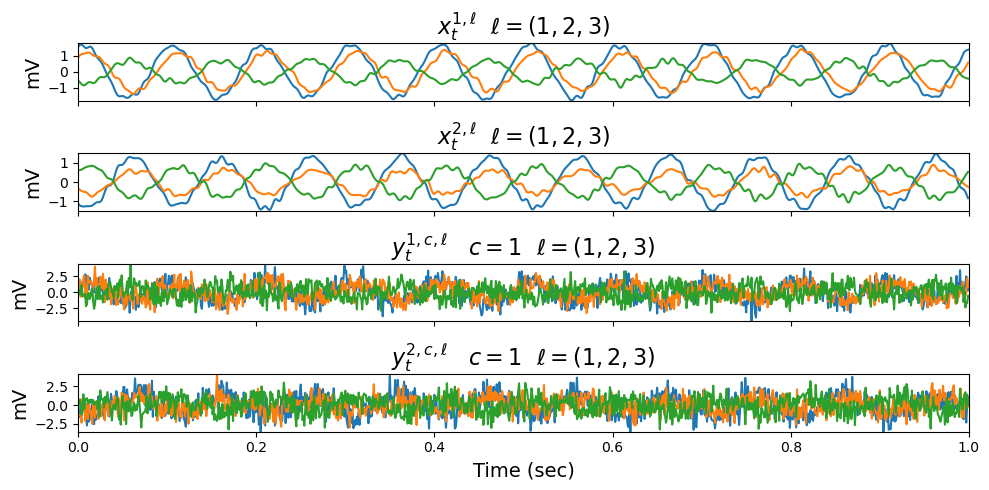

In [3]:
# mu = -1.0
mu = 0.0
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
o1 = 1.0
o2 = 0.0
plot_synthetic_data(K, L, sample_length, C, seed, mu, o1, o2, start=3)



In [4]:
def get_power1(Gamma):
    return Gamma[:,0,0].real

def get_power1dB(Gamma):
    return 10*np.log10(Gamma[:,0,0].real)

def get_coh(Gamma):
    return thr_coherence(Gamma)


from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [5]:

o1 = 8.0
o2 = 1.0
# data_path = f'saved/synthetic_data/simple_synthetic_gaussian_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}'
data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_1_0.0_1.0_0.0_7'
seed = 8
model_path = f'saved/fitted_models/simple_synthetic_gaussian_em10_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}_fitted_analytical'

data_load = pickle_open(data_path)
model_load = pickle_open(model_path)
Gamma = data_load['latent']['Gamma']
zs = data_load['latent']['zs']
xs = data_load['latent']['xs']
ys_avg = model_load['ys_Cavg']
# ys = data_load['observed']['ys']

freqs = data_load['meta']['freqs']

Wv_model = model_load['Wv']
Wv = Wv_model
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int((Wv.shape[1])/2)


In [6]:
func = get_power1dB
Gamma_true = Gamma
func_true = func(Gamma_true[:J_max,:,:])
# func_naive = func(naive[1:J_max+1,:,:])
# model_est = model_load['Gamma']
# func_model = func(model_est)

direct_est = Gamma_est_from_zs(zs[:,:,:J_max+1], dc=False)
func_zs = func(direct_est)

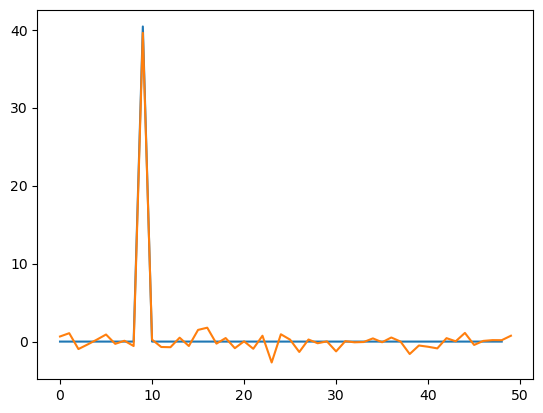

In [7]:
plt.plot(func_true)
plt.plot(func_zs)

In [8]:
model_load['Wv'].shape

(1000, 99)

In [9]:
from scipy.fft import rfft
xs_ft = rfft(xs, axis=2)
ys_ft = rfft(ys_avg, axis=2)


/projectnb/stephenlab/jtauber/cohlib/cohlib/mvcn.py:218: RuntimeWarning: invalid value encountered in divide
  t_coh = num/denom


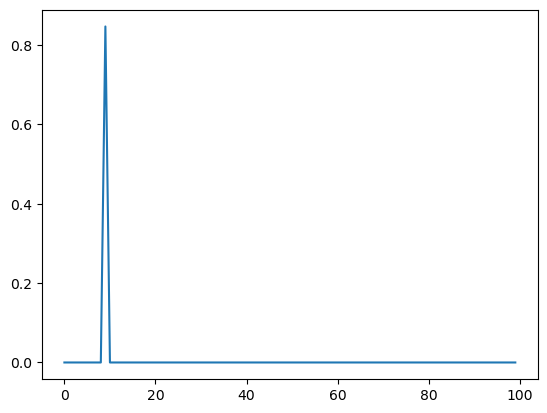

In [10]:
from cohlib.mvcn import thr_coherence
test = thr_coherence(Gamma)
plt.plot(test)

In [11]:
ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj()).mean(3)
xs_ft_outer = np.einsum('lmj,lnj->jmnl', xs_ft,xs_ft.conj()).mean(3)
xys_ft_outer = np.einsum('lmj,lnj->jmnl', xs_ft,ys_ft.conj()).mean(3)

/scratch/264913.1.ood/ipykernel_2405131/3436913063.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(a/b)


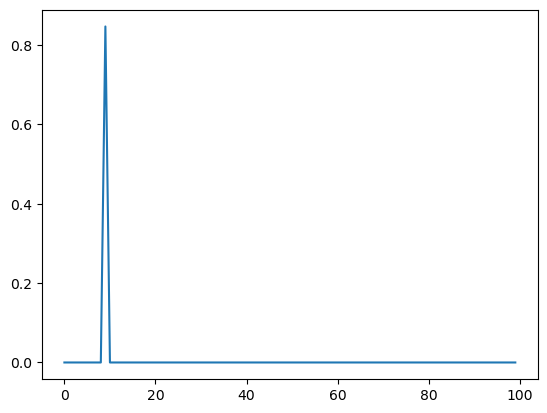

In [12]:
Gamma.shape
a = np.abs(Gamma[:,0,1])**2
b = Gamma[:,0,0].real * Gamma[:,1,1].real
plt.plot(a/b)

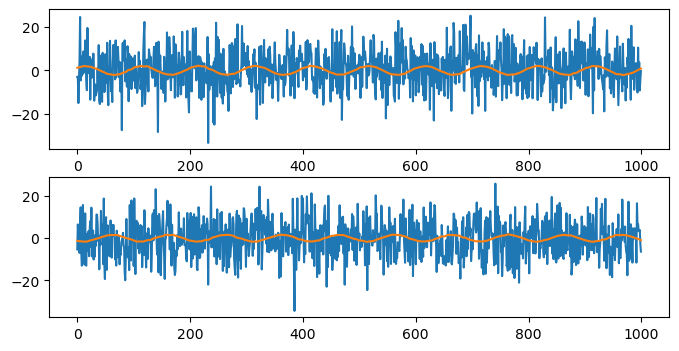

In [13]:
l = 2
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(ys_avg[l,0,:])
ax[1].plot(ys_avg[l,1,:])
ax[0].plot(xs[l,0,:])
ax[1].plot(xs[l,1,:])


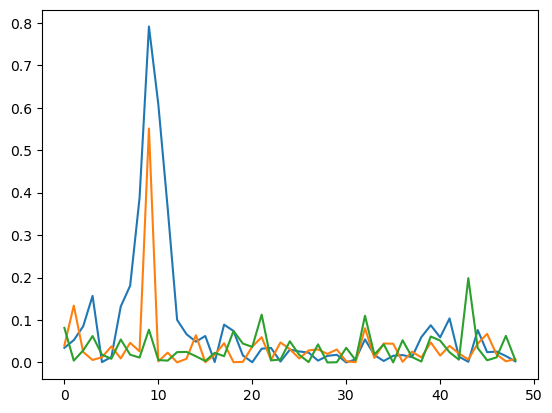

In [14]:
from cohlib.mvcn import estimate_coherence
coh_x1x2 = estimate_coherence(xs_ft[:,0,:], xs_ft[:,1,:])
coh_y1y2 = estimate_coherence(ys_ft[:,0,:], ys_ft[:,1,:])
coh_x1y2 = estimate_coherence(xs_ft[:,0,:], ys_ft[:,1,:])
plt.plot(coh_x1x2[1:50])
plt.plot(coh_y1y2[1:50])
plt.plot(coh_x1y2[1:50])

so we'll want:
- the true coherence of latent (from model)
- oracle coherence from samples x 
- xy coherence
- yy coherence 

but only need mean over C for ys 

In [20]:
from numpy.fft import rfft
from cohlib.mvcn import estimate_coherence
def load_and_calc(func, K, L, sample_length, C, mu, ov1, ov2, estep_type):
    # data_path = f'saved/synthetic_data/simple_synthetic_gaussian_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}'
    data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_1_0.0_1.0_0.0_7'
    data_load = pickle_open(data_path)

    if estep_type == 'approx':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted'
    elif estep_type == 'analytical':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_analytical'
    model_load = pickle_open(model_path)
    print(f'{K} {L} {C} {mu}')

    # ys = data_load['observed']['ys']
    Gamma_true = data_load['latent']['Gamma']
    zs = data_load['latent']['zs']
    xs = data_load['latent']['xs']
    Wv_data = data_load['meta']['Wv']
    freqs = data_load['meta']['freqs']

    ys_avg = model_load['ys_Cavg']
    Wv_model = model_load['Wv']
    Wv = Wv_model
    freqs_mod = freqs[:int((Wv.shape[1] - 1) / 2)]

    J = int((Wv.shape[1]-1)/2)

    # ys_ft = rfft(ys, axis=3).mean(1)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    ys_ft = rfft(ys_avg, axis=2)
    ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    naive = ys_ft_outer.mean(3)
    naive = naive/1000



    func_true = func(Gamma_true[:J_max,:,:])
    func_naive = func(naive[1:J_max+1,:,:])
    model_est = model_load['Gamma']
    func_model = func(model_est)

    direct_est = Gamma_est_from_zs(zs[:,:,:J_max+1], dc=False)
    func_zs = func(direct_est)

    return func_true, func_zs, func_model, func_naive

In [21]:
# great - so next create alg for point process with (known) mu param
# do separate work related to that
# then redo gaussian with no DC and finer range o1 across o2 = 2 / 1
# THEN repeat in point process case 
# then work out analytically why/why not similar 
# - should really calculate the *theoretical spectrum* and show noise-dependence
# finally - thinking about global coh case

In [22]:
J_max

49

In [23]:
L

25

In [25]:
Cs = [1,10,25,500]
ovs = [2.0, 0.0, -2.0]
J_max = 49

num_groups = K
num_trials = L

o1 = 1.0
power1s = np.zeros((len(Cs), len(ovs), 4, J_max))
power1dBs = np.zeros((len(Cs), len(ovs), 4, J_max))
for c, num_neurons in enumerate(Cs):
    for i2, o2 in enumerate(ovs):
        power1_true, power1_zs, power1_model, power1_naive = load_and_calc(get_power1, num_groups, num_trials, 1000, num_neurons, mu, o1, o2, 'analytical')
        power1s[c,i2,0,:] = power1_true
        power1s[c,i2,1,:] = power1_zs[:-1]
        power1s[c,i2,2,:] = power1_model
        power1s[c,i2,3,:] = power1_naive * (2*np.pi)**2

        power1dBs[c,i2,0,:] = 10*np.log10(power1_true)
        power1dBs[c,i2,1,:] = 10*np.log10(power1_zs[:-1])
        power1dBs[c,i2,2,:] = 10*np.log10(power1_model)
        power1dBs[c,i2,3,:] = 10*np.log10(power1_naive * (2*np.pi)**2)

2 25 1 0.0
2 25 1 0.0
2 25 1 0.0
2 25 10 0.0
2 25 10 0.0
2 25 10 0.0
2 25 25 0.0
2 25 25 0.0
2 25 25 0.0
2 25 500 0.0
2 25 500 0.0
2 25 500 0.0


In [26]:
num_em = 10
from numpy.fft import rfft

def plot_power1dB_ov_c():
    fig, ax = plt.subplots(4,3, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(ovs)):
            power1dB_true = power1dBs[i1,i2,0,:] 
            power1dB_zs = power1dBs[i1,i2,1,:] 
            power1dB_model = power1dBs[i1,i2,2,:] 
            power1dB_naive = power1dBs[i1,i2,3,:] 

            ax[i1,i2].plot(freqs_mod, power1dB_true, color='k', label='true', linewidth=3)
            ax[i1,i2].plot(freqs_mod, power1dB_naive, linestyle='--', color='tab:red', label='naive')
            ax[i1,i2].plot(freqs_mod, power1dB_zs, color='tab:green', label='direct')
            ax[i1,i2].plot(freqs_mod, power1dB_model, color='tab:blue', linewidth=3, label='model')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, var = 1e{ovs[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

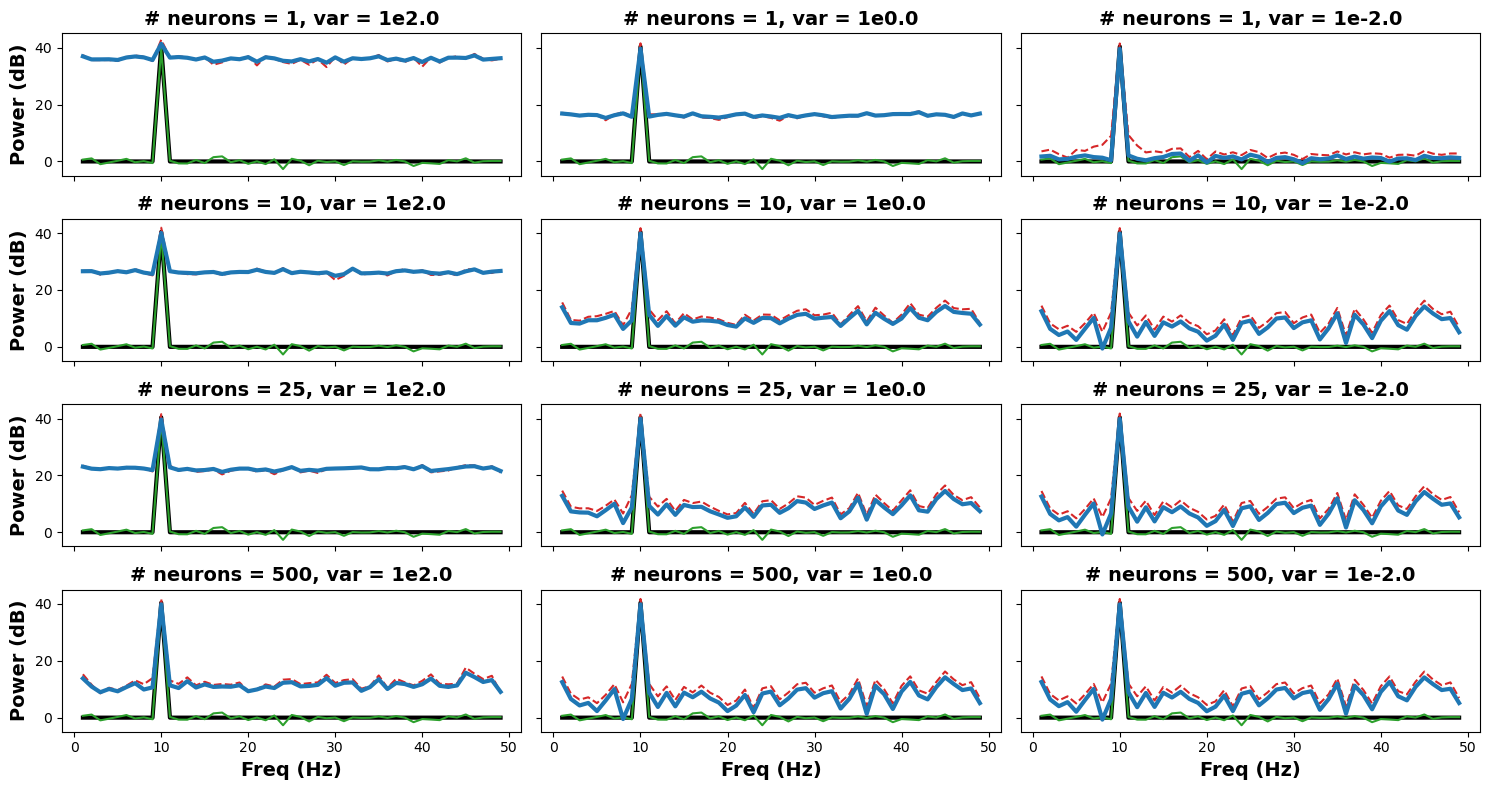

In [27]:
#approx
plot_power1dB_ov_c()

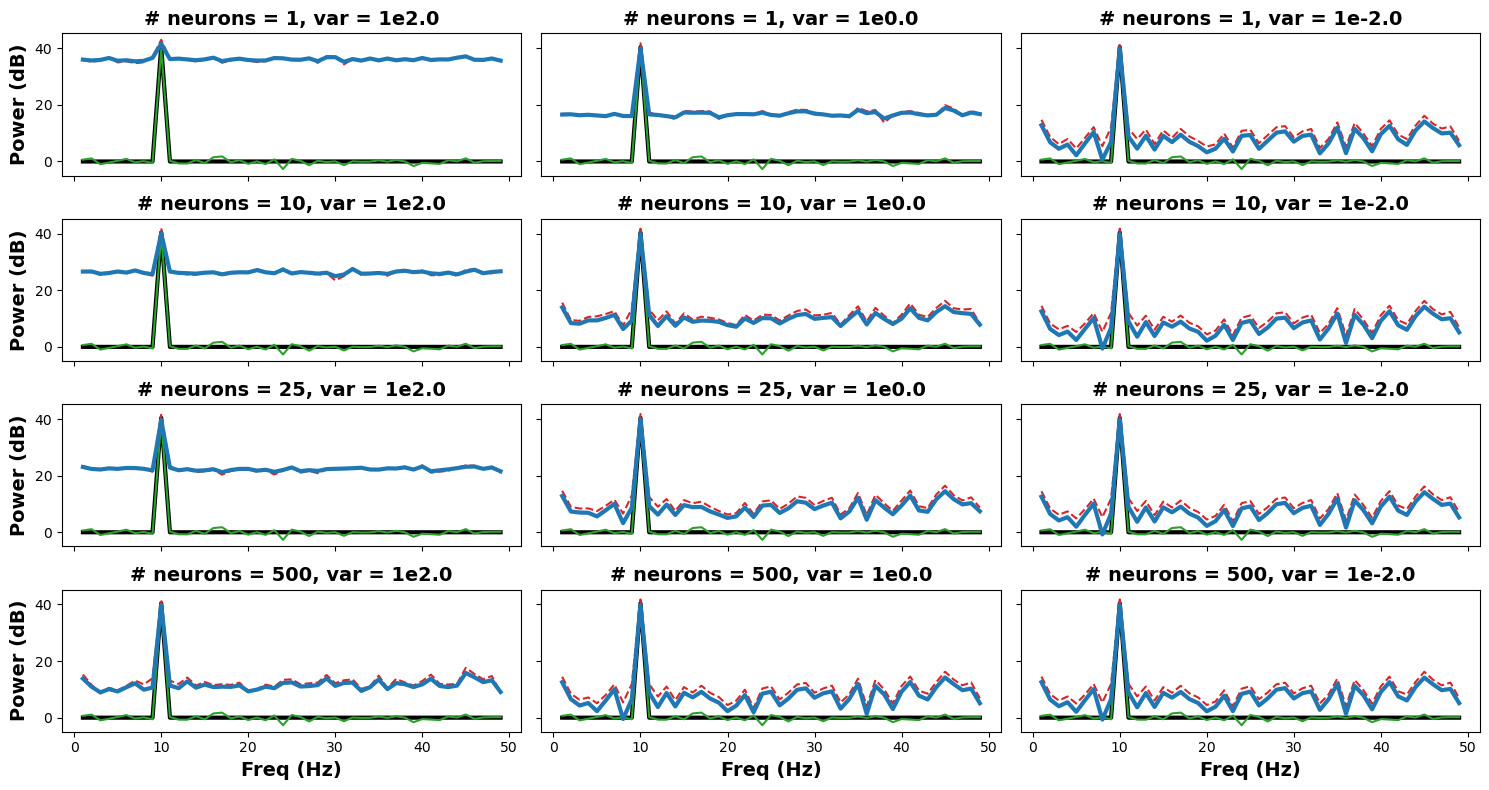

In [74]:
#approx
plot_power1dB_ov_c()

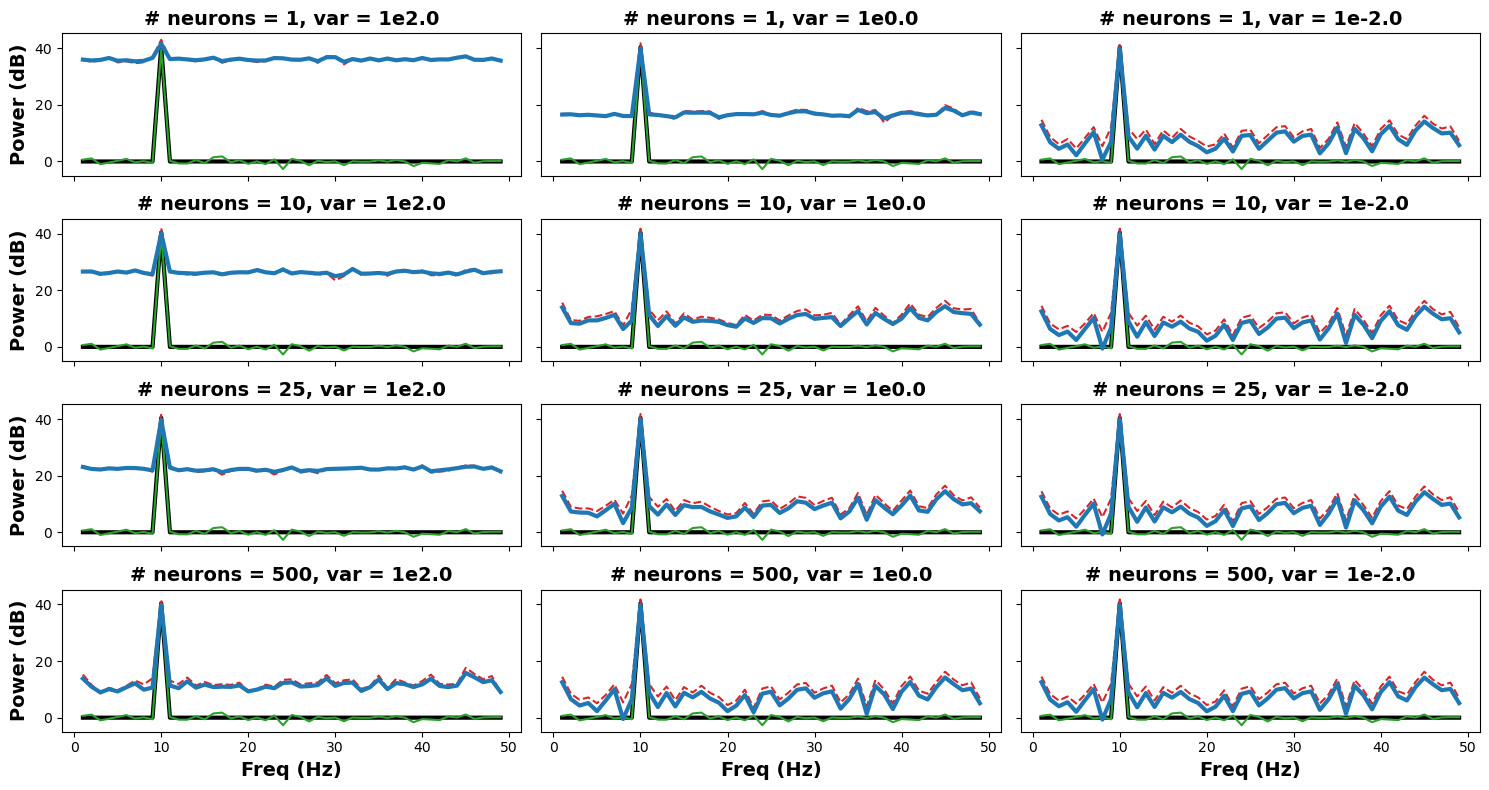

In [ ]:
#approx
plot_power1dB_ov_c()

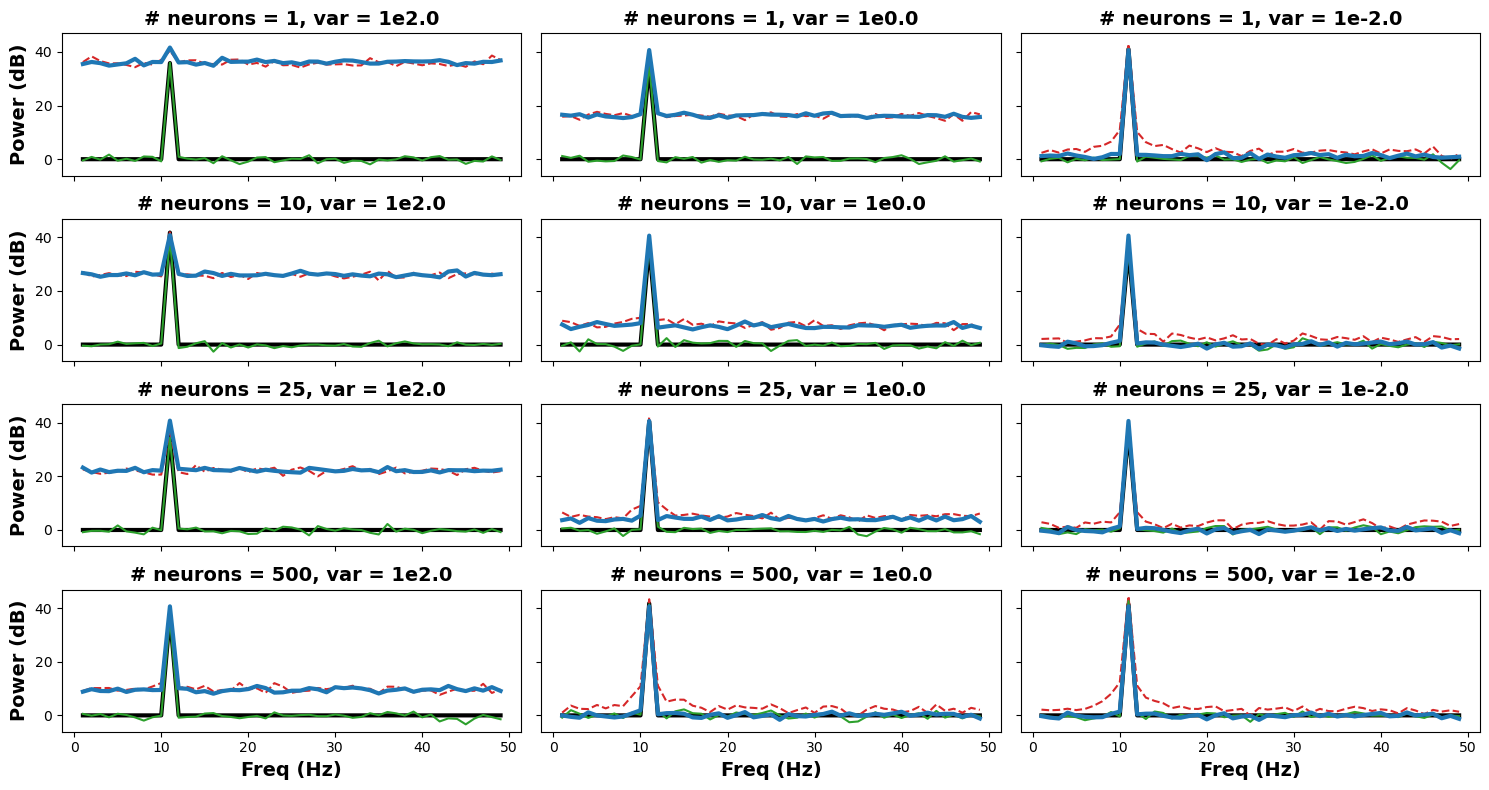

In [18]:
plot_power1dB_ov_c()

In [ ]:
Cs = [1,10,25,500]
ovs = [2.0, 0.0, -2.0]
J_max = 49

num_groups = K
num_trials = L

o1 = 1.0
cohs = np.zeros((len(Cs), len(ovs), 4, J_max))
cohdBs = np.zeros((len(Cs), len(ovs), 4, J_max))
for c, num_neurons in enumerate(Cs):
    for i2, o2 in enumerate(ovs):
        coh_true, coh_zs, coh_model, coh_naive = load_and_calc(get_coh, num_groups, num_trials, 1000, num_neurons, mu, o1, o2, 'analytical')
        cohs[c,i2,0,:] = coh_true
        cohs[c,i2,1,:] = coh_zs
        cohs[c,i2,2,:] = coh_model
        cohs[c,i2,3,:] = coh_naive #* (2*np.pi)**2

        # cohdBs[c,i2,0,:] = 10*np.log10(coh_true)
        # cohdBs[c,i2,1,:] = 10*np.log10(coh_zs)
        # cohdBs[c,i2,2,:] = 10*np.log10(coh_model)
        # cohdBs[c,i2,3,:] = 10*np.log10(coh_naive * (2*np.pi)**2)

2 25 1 0.0
2 25 1 0.0
2 25 1 0.0
2 25 10 0.0
2 25 10 0.0
2 25 10 0.0
2 25 25 0.0
2 25 25 0.0
2 25 25 0.0
2 25 500 0.0
2 25 500 0.0
2 25 500 0.0


In [ ]:
from numpy.fft import rfft

def plot_coh_ov_c():
    fig, ax = plt.subplots(4,3, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(ovs)):
            coh_true = cohs[i1,i2,0,:] 
            coh_zs = cohs[i1,i2,1,:] 
            coh_model = cohs[i1,i2,2,:] 
            coh_naive = cohs[i1,i2,3,:] 

            ax[i1,i2].plot(freqs_mod, coh_true, color='k', label='true', linewidth=3)
            ax[i1,i2].plot(freqs_mod, coh_zs, color='tab:green', label='direct')
            ax[i1,i2].plot(freqs_mod, coh_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, coh_naive, linestyle='--', color='tab:red', label='naive')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, var = 1e{ovs[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

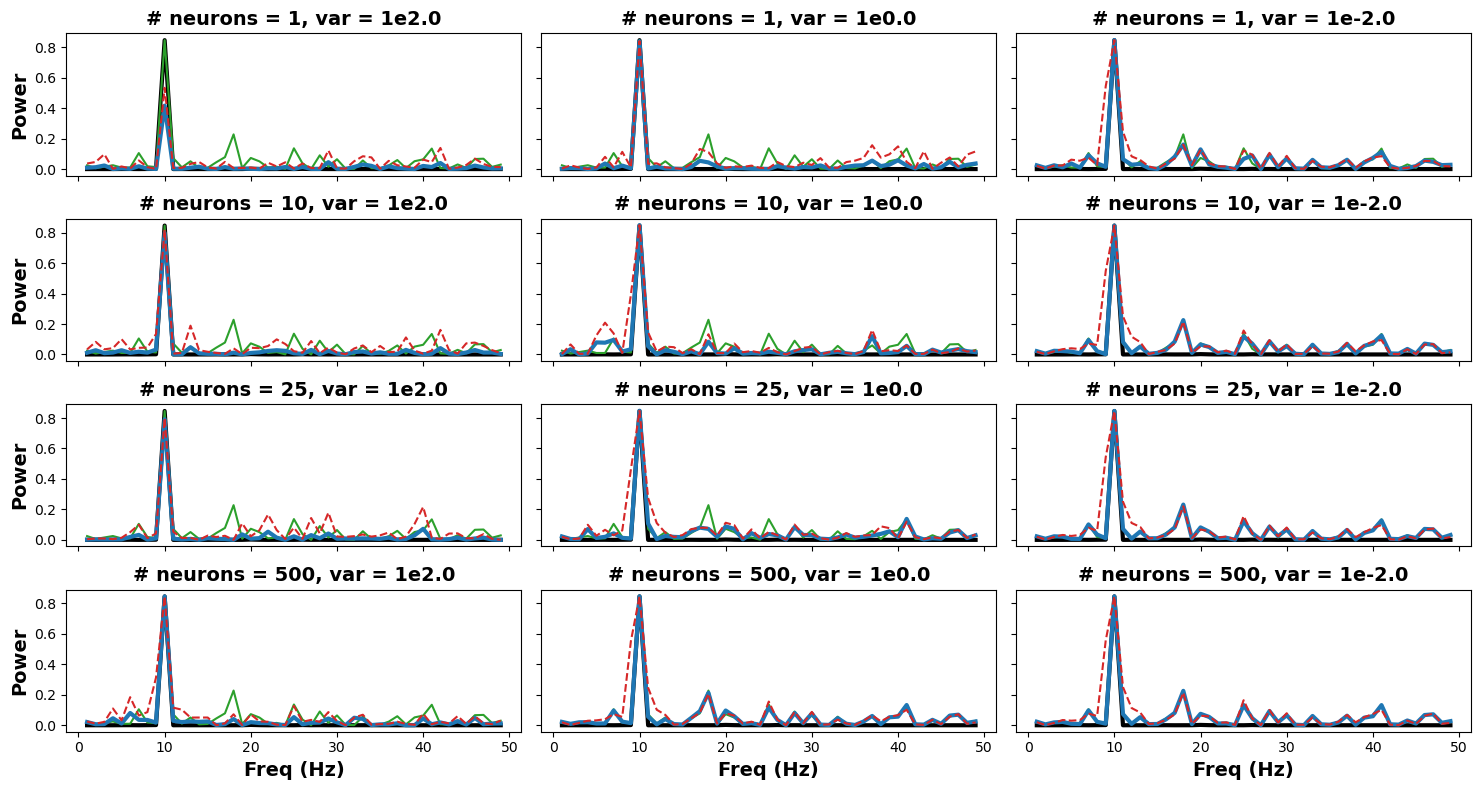

In [ ]:
# approx
plot_coh_ov_c()

In [ ]:
Wv.shape

(1000, 99)

In [ ]:
from numpy.fft import rfft
from cohlib.mvcn import estimate_coherence
def load_and_calc_xy(func, K, L, sample_length, C, mu, ov1, ov2, estep_type, J_max):
    # data_path = f'saved/synthetic_data/simple_synthetic_gaussian_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}'
    data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_1_0.0_1.0_0.0_7'
    data_load = pickle_open(data_path)

    if estep_type == 'approx':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_nodc_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted'
    elif estep_type == 'analytical':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_nodc_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_analytical'
    model_load = pickle_open(model_path)
    print(f'{K} {L} {C} {ov1} {ov2}')

    # ys = data_load['observed']['ys']
    Gamma_true = data_load['latent']['Gamma']
    zs = data_load['latent']['zs']
    xs = data_load['latent']['xs']
    Wv_data = data_load['meta']['Wv']
    freqs = data_load['meta']['freqs']

    ys_avg = model_load['ys_Cavg']
    Wv_model = model_load['Wv']
    Wv = Wv_model
    # freqs_mod = freqs[:int((Wv.shape[1] - 1) / 2)]
    # J = int((Wv.shape[1]-1)/2)

    freqs_mod = freqs[:int((Wv.shape[1]) / 2)]
    J = int((Wv.shape[1])/2)

    # ys_ft = rfft(ys, axis=3).mean(1)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    xs_ft = rfft(xs, axis=2)
    ys_ft = rfft(ys_avg, axis=2)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    # naive = naive/1000
    coh_naive_xx = estimate_coherence(xs_ft[:,0,1:J_max+1], xs_ft[:,1,1:J_max+1])
    coh_naive_yy = estimate_coherence(ys_ft[:,0,1:J_max+1], ys_ft[:,1,1:J_max+1])
    coh_naive_xy = estimate_coherence(xs_ft[:,0,1:J_max+1], ys_ft[:,1,1:J_max+1])

    # func_naive = func(naive[1:J_max+1,:,:])

    func_true = func(Gamma_true[:J_max,:,:])
    model_est = model_load['Gamma']
    func_model = func(model_est)

    # direct_est = Gamma_est_from_zs(zs[:,:,:J_max+1])
    # func_zs = func(direct_est)

    return func_true, func_model, coh_naive_xx, coh_naive_xy, coh_naive_yy

In [ ]:
from numpy.fft import rfft

def plot_coh_ov_c():
    fig, ax = plt.subplots(4,3, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(ovs)):
            coh_true = cohs[i1,i2,0,:] 
            coh_model = cohs[i1,i2,1,:] 
            coh_naive_xx = cohs[i1,i2,2,:] 
            coh_naive_xy = cohs[i1,i2,3,:] 
            coh_naive_yy = cohs[i1,i2,4,:] 

            # ax[i1,i2].plot(freqs_mod, coh_true, color='k', label='true', linewidth=3)
            # ax[i1,i2].plot(freqs_mod, coh_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, coh_naive_xx, linestyle='--', color='tab:red', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_xy, linestyle='--', color='tab:purple', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:green', label='naive')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, var = 1e{ovs[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

In [ ]:
Cs = [1]
# ovs = [2.0, 0.0, -2.0]
o1s = [10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]
o2s = [2.0, 1.0]
J_max = 49

num_neurons = 1
num_groups = K
num_trials = L

o1 = 1.0
cohs = np.zeros((len(o1s), len(o2s), 5, J_max))
cohdBs = np.zeros((len(o1s), len(o2s), 5, J_max))
for i1, o1 in enumerate(o1s):
    for i2, o2 in enumerate(o2s):
        coh_true, coh_model, coh_naive_xx, coh_naive_xy, coh_naive_yy = load_and_calc_xy(get_coh, num_groups, num_trials, 1000, num_neurons, mu, o1, o2, 'analytical', 49)
        cohs[i1,i2,0,:] = coh_true
        cohs[i1,i2,1,:] = coh_model
        cohs[i1,i2,2,:] = coh_naive_xx #* (2*np.pi)**2
        cohs[i1,i2,3,:] = coh_naive_xy #* (2*np.pi)**2
        cohs[i1,i2,4,:] = coh_naive_yy #* (2*np.pi)**2

        # cohdBs[c,i2,0,:] = 10*np.log10(coh_true)
        # cohdBs[c,i2,1,:] = 10*np.log10(coh_zs)
        # cohdBs[c,i2,2,:] = 10*np.log10(coh_model)
        # cohdBs[c,i2,3,:] = 10*np.log10(coh_naive * (2*np.pi)**2)

2 25 1 10.0 2.0
2 25 1 10.0 1.0
2 25 1 9.0 2.0
2 25 1 9.0 1.0
2 25 1 8.0 2.0
2 25 1 8.0 1.0
2 25 1 7.0 2.0
2 25 1 7.0 1.0
2 25 1 6.0 2.0
2 25 1 6.0 1.0
2 25 1 5.0 2.0
2 25 1 5.0 1.0
2 25 1 4.0 2.0
2 25 1 4.0 1.0
2 25 1 3.0 2.0
2 25 1 3.0 1.0
2 25 1 2.0 2.0
2 25 1 2.0 1.0
2 25 1 1.0 2.0
2 25 1 1.0 1.0


In [ ]:
from numpy.fft import rfft

def plot_coh_ov_c():
    fig, ax = plt.subplots(10,2, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(o1s)):
        for i2 in range(len(o2s)):
            coh_true = cohs[i1,i2,0,:] 
            coh_model = cohs[i1,i2,1,:] 
            coh_naive_xx = cohs[i1,i2,2,:] 
            coh_naive_xy = cohs[i1,i2,3,:] 
            coh_naive_yy = cohs[i1,i2,4,:] 

            # ax[i1,i2].plot(freqs_mod, coh_true, color='k', label='true', linewidth=3)
            # ax[i1,i2].plot(freqs_mod, coh_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, coh_naive_xx, linestyle='--', color='tab:blue', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_xy, linestyle='--', color='tab:green', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label='naive')

            ax[i1,i2].set_title(f'# neurons = {1}, var = {o1s[i1]}e{o2s[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Coh', fontweight='bold', fontsize=14)
            if i1 == len(o1s)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

In [ ]:
len(o2s)

2

In [ ]:
cohs.shape

(10, 2, 5, 49)

0.6745962567893342
0.21661237064518926
0.12603589438706247


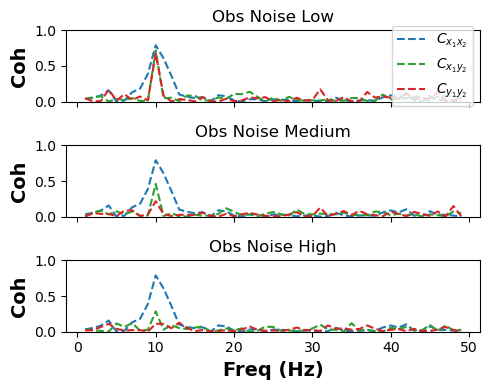

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(5,4), sharex=True, sharey=True)
i1s = []
# o2 = 1
i2 = 0
o1s = [10.0, 5.0, 1.0]

titles = ['Obs Noise Low', 'Obs Noise Medium', 'Obs Noise High']
pairs = [[5,1], [7,0], [0,0]]

for i, pair in enumerate(pairs):
    i1 = pair[0]
    i2 = pair[1]
    coh_naive_xx = cohs[i1,i2,2,:] 
    coh_naive_xy = cohs[i1,i2,3,:] 
    coh_naive_yy = cohs[i1,i2,4,:] 
    print(coh_naive_yy.max())

    ax[i].plot(freqs_mod, coh_naive_xx, linestyle='--', color='tab:blue', label=r'$C_{x_1 x_2}$')
    ax[i].plot(freqs_mod, coh_naive_xy, linestyle='--', color='tab:green', label=r'$C_{x_1 y_2}$')
    ax[i].plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label=r'$C_{y_1 y_2}$')
    ax[i].set_title(titles[i])
    if i == 0:
        ax[i].legend(loc='right')
    ax[i].set_ylabel(f'Coh', fontweight='bold', fontsize=14)
    if i == 2:
        ax[i].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # ax.plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label='naive')
    # ax.plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label='naive')
    ax[i].set_ylim([0,1])
plt.tight_layout()

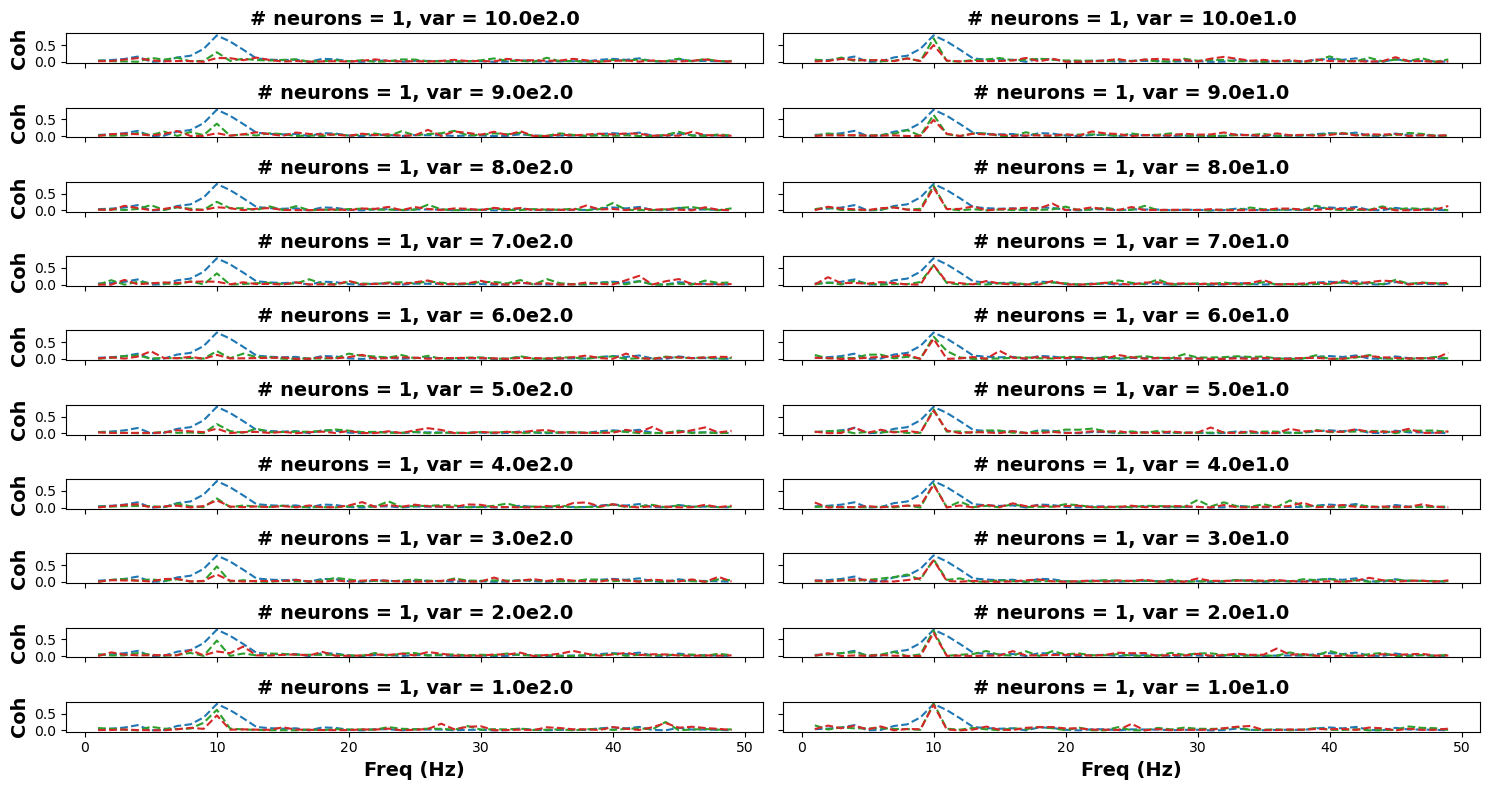

In [ ]:
plot_coh_ov_c()